# P3 CarND-Advanced-Lane-Lines

## 1) Calibrate Camera

No corners found in image: ./camera_cal/calibration1.jpg
No corners found in image: ./camera_cal/calibration4.jpg
No corners found in image: ./camera_cal/calibration5.jpg
img_shape (720, 1280, 3)
img_shape[1::-1] (1280, 720)


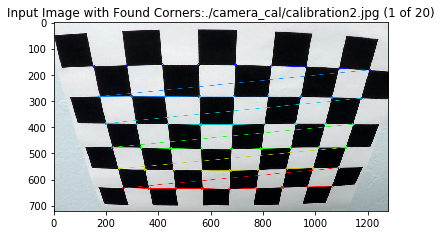

In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Chessboard subpixel termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points
nx = 9 #TODO: enter the number of inside corners in x
ny = 6 #TODO: enter the number of inside corners in y

# Arrays to store object and image points
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates

# Loop through all the calibration images
for fname in images:
    # img = mpimg.imread(fname)
    img = cv2.imread(fname)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # Exit here if corners not found
    if ret == True:
        # set the object and image points
        objpoints.append(objp)

        #imgpoints.append(corners)
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        if fname == './camera_cal/calibration2.jpg':
            # Draw and display the corners
            plt.title('Input Image with Found Corners:'+fname+' (1 of '+str(len(images))+')')
            cv2.drawChessboardCorners(img, (nx, ny), corners2, ret)
            plt.imshow(img)
            first_image = img
    else:
        print("No corners found in image:",fname)
        #plt.title('Input Image')
        #plt.imshow(img)
        #break

# Now calculate the Camera calibration matrix
#ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
print ("img_shape",first_image.shape)
print ("img_shape[1::-1]",first_image.shape[1::-1])
ret, cc_mtx, cc_dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, first_image.shape[1::-1], None, None)


## 2) Undistort Function (Calibration Image Example)

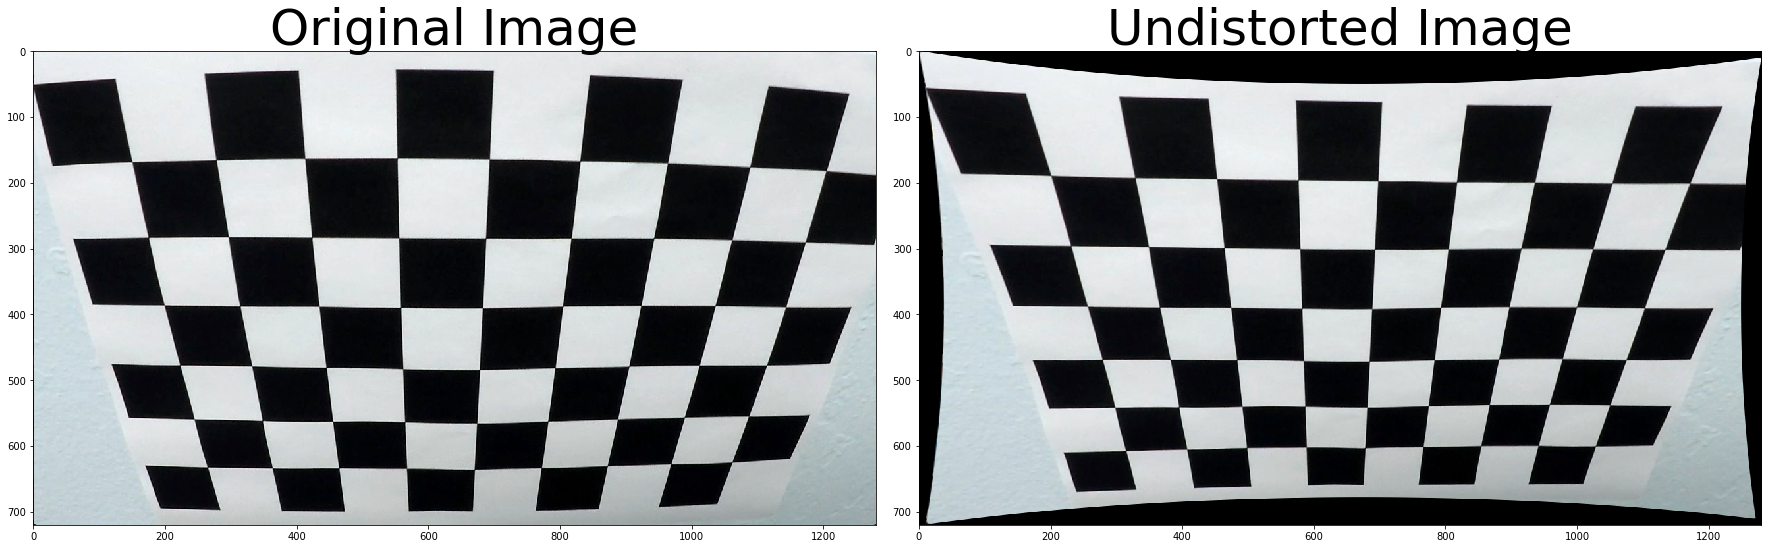

In [2]:
# Read in an image
img = cv2.imread('./camera_cal/calibration2.jpg')

# Function that takes an image and camera calibrations then performs
# the camera calibration optimization, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, mtx, dist):
    # Use cv2.calibrateCamera() and cv2.undistort()
    #print ("img_shape",img.shape)
    #print ("img_shape[1::-1]",img.shape[1::-1])
    #ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    #undist = cv2.undistort(img, mtx, dist, None, mtx)

    # Use cv2.getOptimalNewCameraMatrix() and cv2.undistort()
    h,  w = img.shape[:2]
    # Calc Optimal Camera matrix
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
    # undistort
    undist = cv2.undistort(img, mtx, dist, None, newcameramtx)
    return undist

undistorted = cal_undistort(img, cc_mtx, cc_dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('./examples/undistort_output_mrl.png')

## 2a) Undistorted Test Image Example

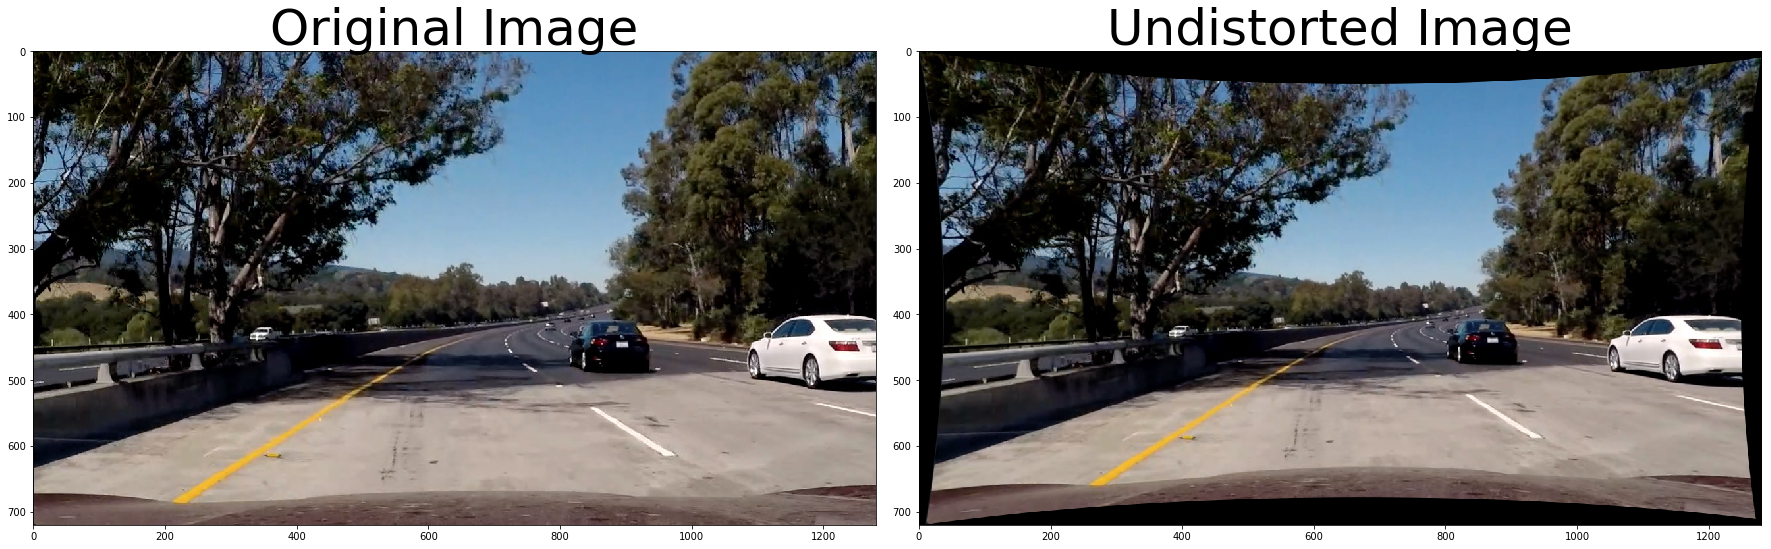

In [3]:
# Read in an image
#img = cv2.imread('./test_images/test1.jpg')
img = cv2.imread('./test_images/test5.jpg')
h,  w = img.shape[:2]
# Calc Optimal Camera matrix
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(cc_mtx, cc_dist, (w,h),1,(w,h))

# undistort
dst = cv2.undistort(img, cc_mtx, cc_dist, None, newcameramtx)

# crop the image
x,y,w,h = roi
#dst = dst[y:y+h, x:x+w]
#cv2.imwrite('calibresult.png',dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
#ax1.imshow(img)
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=50)
#ax2.imshow(dst)
ax2.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#plt.savefig('./examples/test1_undist_mrl.png')

## 3) Threshold Gradient Pipeline

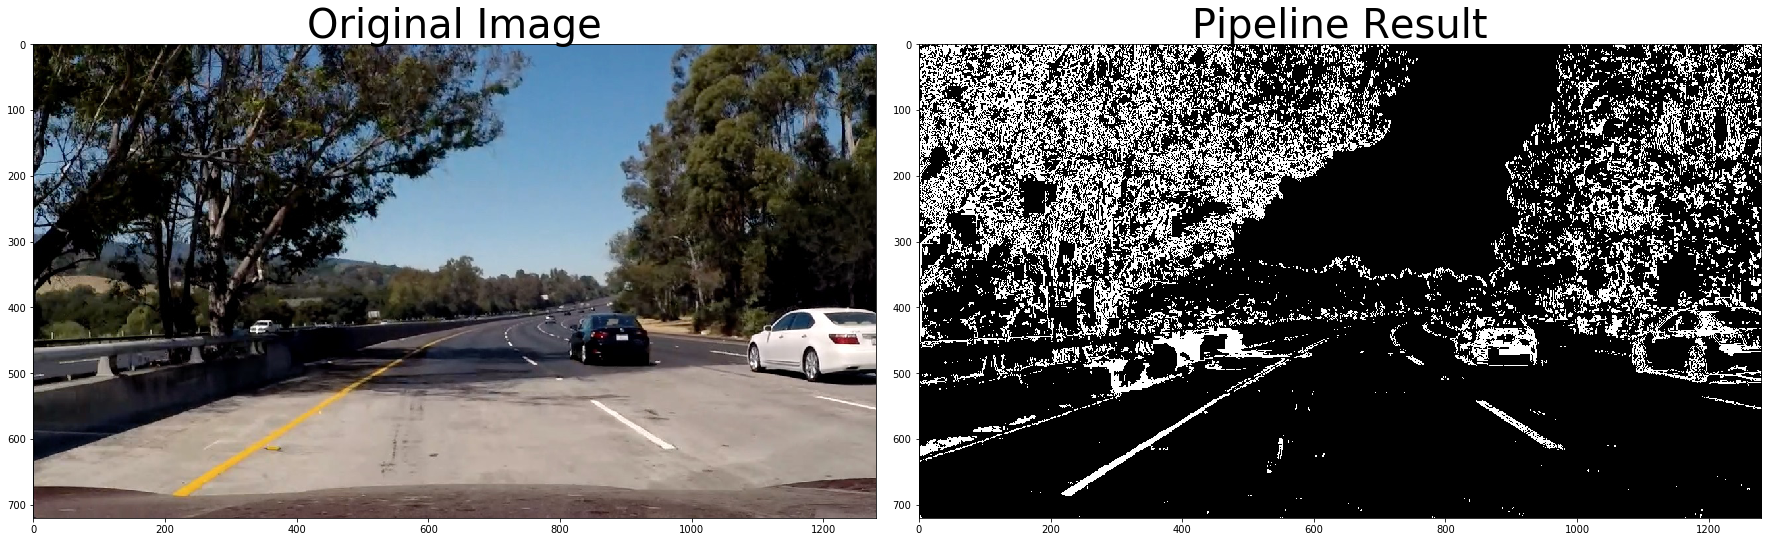

In [4]:
# Udacity L13.30 Advanced Lane Finding - Color and Gradient

#image = cv2.imread('./test_images/test1.jpg')
image = cv2.imread('./test_images/test5.jpg')

# Edit this function to create your own pipeline.
def tg_pipeline(tg_img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(tg_img, cv2.COLOR_BGR2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1    
    
    return combined_binary
    
tg_result = tg_pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(tg_result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#plt.savefig('./examples/binary_combo_example_mrl.png')

## 4) Unwarp Function (Undistort and Transform Example)

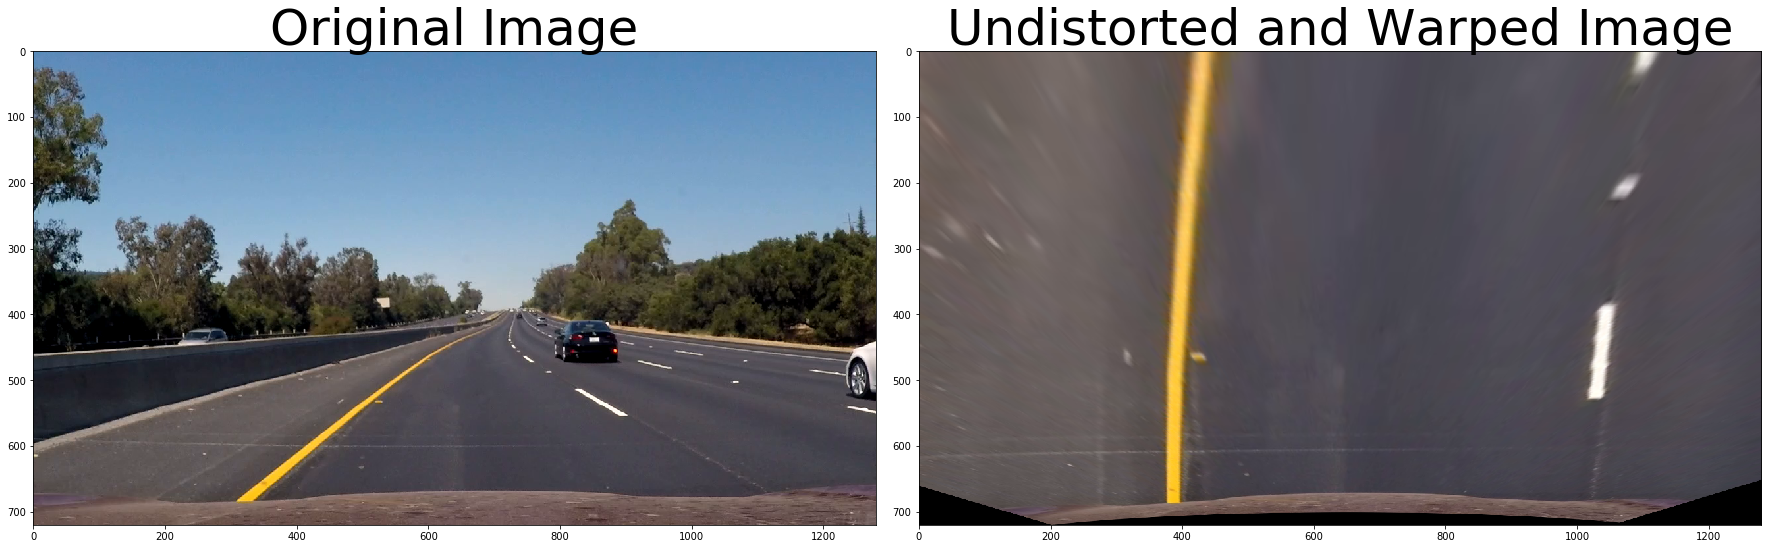

In [5]:
# Read in an image
#uw_img = cv2.imread('./test_images/straight_lines1.jpg')
#uw_img = cv2.imread('./test_images/straight_lines2.jpg')
#uw_img = cv2.imread('./test_images/test1.jpg')
#uw_img = cv2.imread('./test_images/test5.jpg')
#uw_img = cv2.imread('./test_images/vid_in_2017-10-09_223406.jpg')
uw_img = cv2.imread('./test_images/vid_in_2017-10-10_215748.jpg')

# Unwarp function takes input of undistorted image, number of x,y image points in corners
#def corners_unwarp(undist, nx, ny, corners):
def corners_unwarp(cu_undist, src, dst):

    # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
         #Note: you could pick any four of the detected corners 
         # as long as those four corners define a rectangle
         #One especially smart way to do this would be to use four well-chosen
         # corners that were automatically detected during the undistortion steps
         #We recommend using the automatic detection of corners in your code
    # For source points I'm grabbing the outer four detected corners
    #print("len(Imgpoints)=",len(corners))
    #print("Imgpoints[0]=",corners[0])
    # Use the first set of image points test_image2 I believe
    #src = np.float32([corners[0][0], corners[0][nx-1], corners[0][-1], corners[0][-nx]])
    #print("source points=",src)

    # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    #img_size = (undist.shape[1], undist.shape[0])
    #offset = 100
    #dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
    #                             [img_size[0]-offset, img_size[1]-offset], 
    #                             [offset, img_size[1]-offset]])

    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    # Compute the perspective transform, M, given source and destination points:
    M = cv2.getPerspectiveTransform(src, dst)

    # e) use cv2.warpPerspective() to warp your image to a top-down view
    # Warp an image using the perspective transform, M:
    cu_img_size = (cu_undist.shape[1], cu_undist.shape[0])
    warped = cv2.warpPerspective(cu_undist, M, cu_img_size, flags=cv2.INTER_LINEAR)

    return warped, M

# Undistort the input image
undist = cal_undistort(uw_img, cc_mtx, cc_dist)
    
# Hardcoded straight lane example points
img_size = (undist.shape[1], undist.shape[0])
far_xoffset = 55 #orig 55
near_rxoffset = 30 #orig 10
near_lxoffset = 70 #orig 60
yoffset = 100 # orig 100
src = np.float32(
    [[(img_size[0] / 2) - far_xoffset, img_size[1] / 2 + yoffset],
    [((img_size[0] / 6) - near_rxoffset), img_size[1]],
    [(img_size[0] * 5 / 6) + near_lxoffset, img_size[1]],
    [(img_size[0] / 2 + far_xoffset + 25), img_size[1] / 2 + yoffset]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
#print("src=",src)
#print("dst=",dst)

# Warp
#top_down, perspective_M = corners_unwarp(undist, nx, ny, imgpoints)
top_down, perspective_M = corners_unwarp(undist, src, dst)
# Compute the inverse perspective transform:
Minv = cv2.getPerspectiveTransform(dst, src)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
red = (0,0,255)
line_width = 3
cv2.line(img,(src[0][0],src[0][1]),(src[1][0],src[1][1]),red,line_width)
cv2.line(img,(src[0][0],src[0][1]),(src[3][0],src[3][1]),red,line_width)
cv2.line(img,(src[3][0],src[3][1]),(src[2][0],src[2][1]),red,line_width)

ax1.imshow(cv2.cvtColor(uw_img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(cv2.cvtColor(top_down, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#plt.savefig('./examples/warped_straight_lines_mrl.png')
#plt.savefig('./examples/warped_straight_lines2_mrl.png')


## 5) Top Down Image

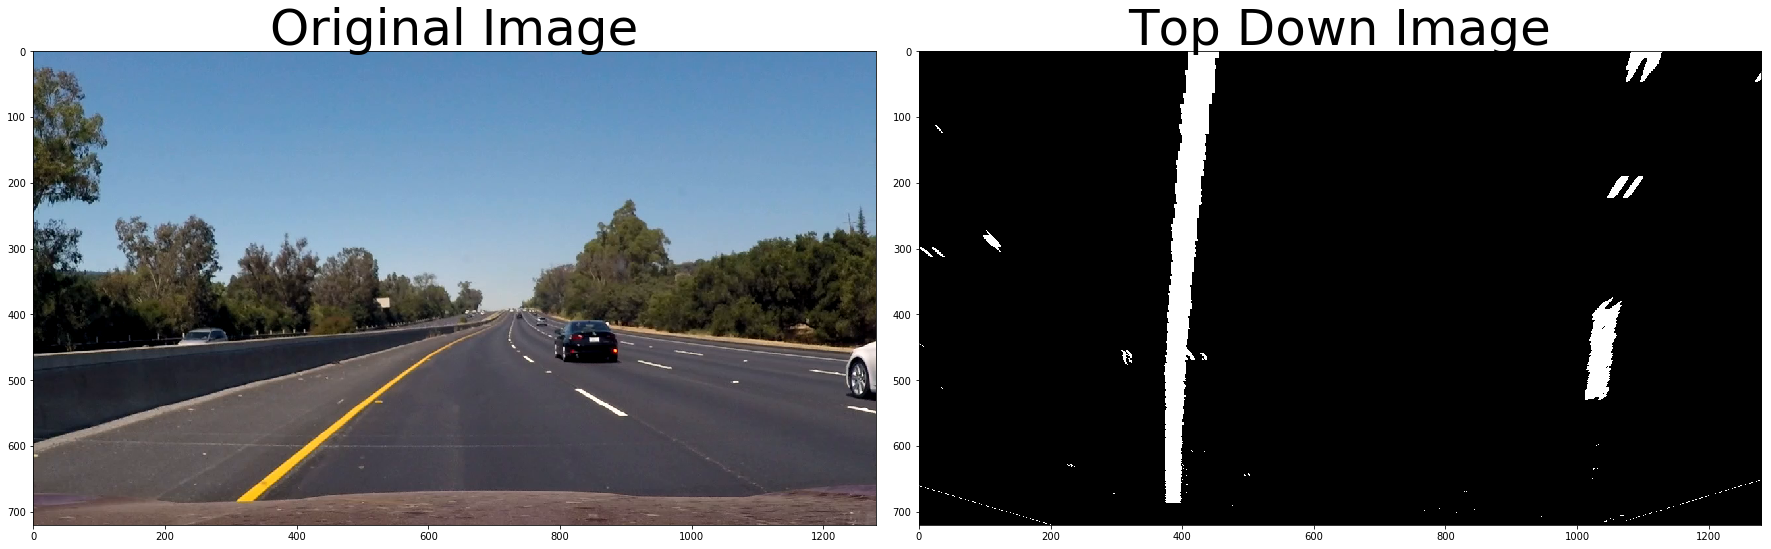

In [6]:
# Read in an image
#td_img = cv2.imread('./test_images/straight_lines1.jpg')
#td_img = cv2.imread('./test_images/straight_lines2.jpg')
#td_img = cv2.imread('./test_images/test5.jpg')
#td_img = cv2.imread('./test_images/vid_in_2017-10-09_223406.jpg')
td_img = cv2.imread('./test_images/vid_in_2017-10-10_215748.jpg')


# Undistort the input image
_undist = cal_undistort(td_img, cc_mtx, cc_dist)

# Threshold
_tg_result = tg_pipeline(_undist)

# Perspective
_top_down, perspective_M = corners_unwarp(_tg_result, src, dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(td_img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(_top_down, cmap='gray')
ax2.set_title('Top Down Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#plt.savefig('./examples/warped_straight_lines_mrl.png')
#plt.savefig('./examples/warped_straight_lines2_mrl.png')


## 6) Top Down Histogram

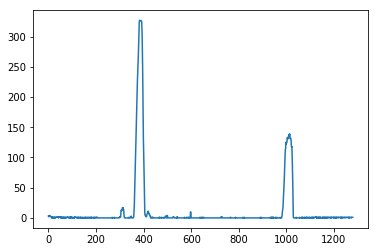

In [18]:
histogram = np.sum(top_down[top_down.shape[0]//2:,:], axis=0)
plt.plot(histogram)

## 7) Polynomial Fit Find Function

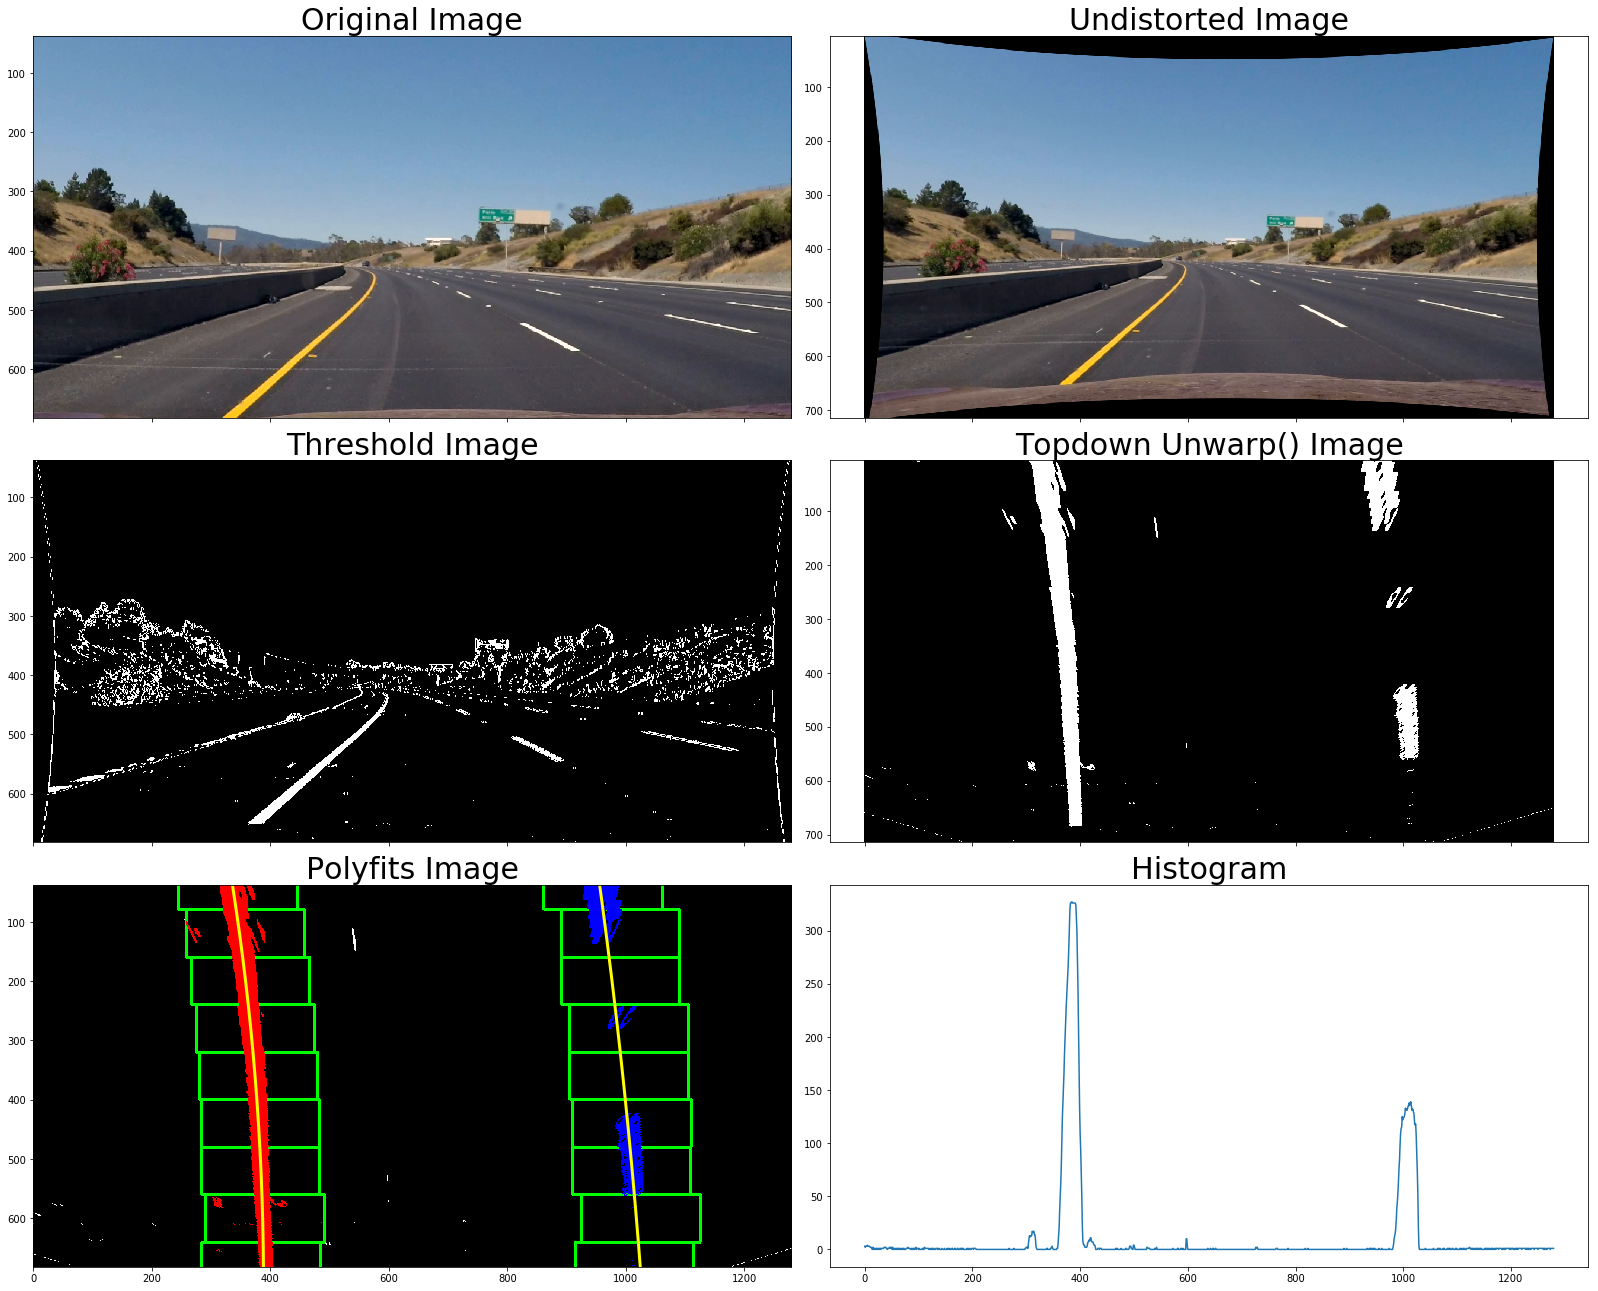

In [7]:
def polyfit_find(pf_topdown):

    # Take a histogram of the bottom half of the image
    histogram = np.sum(pf_topdown[pf_topdown.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(pf_topdown.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = pf_topdown.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    window_points = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = pf_topdown.shape[0] - (window+1)*window_height
        win_y_high = pf_topdown.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3)
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        window_points.append([(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(win_xright_low,win_y_low),(win_xright_high,win_y_high)])
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    return left_lane_inds, right_lane_inds, nonzerox, nonzeroy, window_points, histogram

# Read in an image
#pff_img = cv2.imread('./test_images/straight_lines1.jpg')
#pff_img = cv2.imread('./test_images/straight_lines2.jpg')
#pff_img = cv2.imread('./test_images/test5.jpg')
pff_img = cv2.imread('./test_images/vid_in_2017-10-09_223406.jpg')
#pff_img = cv2.imread('./test_images/vid_in_2017-10-10_215748.jpg')

# Undistort the input image
pff_undist = cal_undistort(pff_img, cc_mtx, cc_dist)

# Threshold
pff_tg_result = tg_pipeline(pff_undist)

# Perspective
pff_top_down, perspective_M = corners_unwarp(pff_tg_result, src, dst)

out_img = np.dstack((pff_top_down, pff_top_down, pff_top_down))*255
#out_img = np.zeros_like(top_down)

# Generate y values for plotting
pff_ploty = np.linspace(0, pff_top_down.shape[0]-1, pff_top_down.shape[0] )
pff_left_lane_inds, pff_right_lane_inds, pff_nonzerox, pff_nonzeroy, window_points, pff_histogram = polyfit_find(pff_top_down)

# Extract left and right line pixel positions
pff_leftx = pff_nonzerox[pff_left_lane_inds]
pff_lefty = pff_nonzeroy[pff_left_lane_inds] 
pff_rightx = pff_nonzerox[pff_right_lane_inds]
pff_righty = pff_nonzeroy[pff_right_lane_inds]

# Fit a second order polynomial to each
pff_left_fit = np.polyfit(pff_lefty, pff_leftx, 2)
pff_right_fit = np.polyfit(pff_righty, pff_rightx, 2)

# Generate x and y values for plotting
pff_left_fitx = pff_left_fit[0]*pff_ploty**2 + pff_left_fit[1]*pff_ploty + pff_left_fit[2]
pff_right_fitx = pff_right_fit[0]*pff_ploty**2 + pff_right_fit[1]*pff_ploty + pff_right_fit[2]

#print (window_points[0][0], window_points[0][1],window_points[0][2],window_points[0][3])
for window in window_points:
 cv2.rectangle(out_img,window[0],window[1],(0,255,0), 3)
 cv2.rectangle(out_img,window[2],window[3],(0,255,0), 3) 


f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(24, 9), sharex='col')
f.tight_layout()
ax1.imshow(cv2.cvtColor(pff_img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(pff_undist, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=30)
ax3.imshow(pff_tg_result, cmap='gray')
ax3.set_title('Threshold Image', fontsize=30)
ax4.imshow(pff_top_down, cmap='gray')
ax4.set_title('Topdown Unwarp() Image', fontsize=30)
out_img[pff_nonzeroy[pff_left_lane_inds], pff_nonzerox[pff_left_lane_inds]] = [255, 0, 0]
out_img[pff_nonzeroy[pff_right_lane_inds], pff_nonzerox[pff_right_lane_inds]] = [0, 0, 255]
ax5.imshow(out_img)
ax5.plot(pff_left_fitx, pff_ploty, color='yellow', linewidth=3)
ax5.plot(pff_right_fitx, pff_ploty, color='yellow', linewidth=3)
#ax5.xlim(0, 1280)
#ax5.ylim(720,  0)
ax5.set_title('Polyfits Image', fontsize=30)
#ax6.imshow(cv2.cvtColor(pff_img, cv2.COLOR_BGR2RGB))
#ax6.set_title('Original Image', fontsize=30)
ax6.plot(pff_histogram)
ax6.set_title('Histogram', fontsize=30)
plt.subplots_adjust(left=0., right=.9, top=1.9, bottom=0.)

#out_img[pff_nonzeroy[pff_left_lane_inds], pff_nonzerox[pff_left_lane_inds]] = [255, 0, 0]
#out_img[pff_nonzeroy[pff_right_lane_inds], pff_nonzerox[pff_right_lane_inds]] = [0, 0, 255]
#plt.imshow(out_img)
#plt.plot(pff_left_fitx, ploty, color='yellow', linewidth=3)
#plt.plot(pff_right_fitx, ploty, color='yellow', linewidth=3)
#plt.xlim(0, 1280)
#plt.ylim(720,  0)

## 7) Polynomial Fit Next Frame

(720, 0)

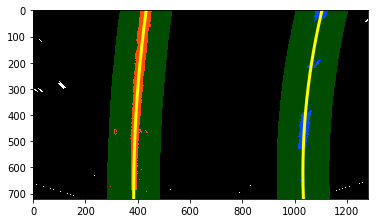

In [43]:
def polyfit_next(topdown, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "top_down")
    # It's now much easier to find line pixels!
    nonzero = top_down.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    left_fit_new = None
    right_fit_new = None
    if len(leftx) != 0:
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, top_down.shape[0]-1, top_down.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds, nonzerox, nonzeroy

# margin must match that used above
margin = 100
left_fit_new, right_fit_new, left_lane_inds, right_lane_inds, nonzerox, nonzeroy = polyfit_next(top_down, left_fit, right_fit)

# And you're done! But let's visualize the result here as well
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((top_down, top_down, top_down))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow', linewidth=3)
plt.plot(right_fitx, ploty, color='yellow', linewidth=3)
plt.xlim(0, 1280)
plt.ylim(720, 0)

## 8) Measuring Curvature

In [8]:
def get_curvature(leftx, lefty, rightx, righty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(lefty)
    #print ("max ploty",y_eval)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curverad, right_curverad


def get_dist(img_center, img_height, gd_left_fit, gd_right_fit):
    center_dist = 0.0
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if gd_left_fit is not None and gd_right_fit is not None:
        left_fit_x_int = gd_left_fit[0]*img_height**2 + gd_left_fit[1]*img_height + gd_left_fit[2]
        right_fit_x_int = gd_right_fit[0]*img_height**2 + gd_right_fit[1]*img_height + gd_right_fit[2]
        lane_center_position = (right_fit_x_int + left_fit_x_int) / 2
        center_dist = (img_center - lane_center_position) * xm_per_pix
    return center_dist



left_curverad, right_curverad = get_curvature(pff_leftx, pff_lefty, pff_rightx, pff_righty)
# Now our radius of curvature is in meters
print('left:',left_curverad, 'm, right:', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

center_dist = get_dist(pff_top_down.shape[1]/2, pff_top_down.shape[0], pff_left_fit, pff_right_fit)
print('Dist: ',center_dist, '   center:',pff_top_down.shape[1]/2)

print('get_curvature() and get_dist() defined')


left: 1428.48814977 m, right: 3526.91709961 m
Dist:  -0.35881938241    center: 640.0
get_curvature() and get_dist() defined


## 8a) Draw Measurement

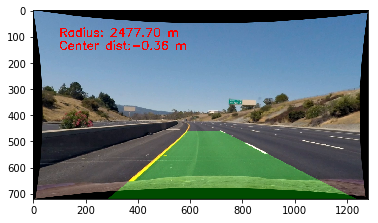

In [14]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(pff_top_down).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([pff_left_fitx, pff_ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([pff_right_fitx, pff_ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(pff_undist, 1, newwarp, 0.3, 0)

left_curverad, right_curverad = get_curvature(pff_leftx, pff_lefty, pff_rightx, pff_righty) 
curverad_str = "Radius: " + "{:.2f}".format((left_curverad + right_curverad) / 2) + " m"
cv2.putText(result, curverad_str, (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,0,255), thickness=3)

center_dist = get_dist(pff_top_down.shape[1]/2, pff_top_down.shape[0], pff_left_fit, pff_right_fit)
dist_str = "Center dist:" + "{:.2f}".format(center_dist) + " m"
cv2.putText(result, dist_str, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,0,255), thickness=3)

plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))



## 9) Tracking Class

In [21]:
# Define a class to receive the characteristics of each line detectionimport collections
import collections

class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        #self.current_fit = [np.array([False])]
        self.current_fit = collections.deque()
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
 
    def new_fit(self, fit):
        if fit is not None:
            self.current_fit.append(fit)
            # Keep the average to <= 5
            if len(self.current_fit) > 5:
                self.current_fit.remove(self.current_fit[0])
            # Set best_fit to their average
            self.best_fit = np.average(self.current_fit, axis=0)
        
print('fini...')

fini...


# 10) Putting It All Together

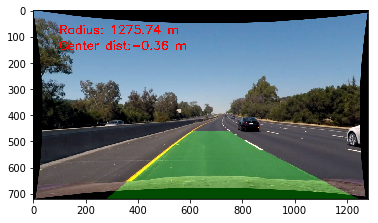

In [33]:
import time, datetime

def process_image2(pi2_input_image):
    pi2_img = np.copy(pi2_input_image)

    # Use these images to debug
    #ts = time.time()
    #st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d_%H%M%S')
    #plt.imsave('output_images/vid_in_'+st+'.jpg', pi2_image)    
    
    # Undistort the input image
    pi_undist = cal_undistort(pi2_img, cc_mtx, cc_dist)

    # Threshold
    pi_tg_result = tg_pipeline(pi_undist)

    # Perspective
    top_down, perspective_M = corners_unwarp(pi_tg_result, src, dst)
    # Compute the inverse perspective transform:
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Top Down Plot
    #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    #f.tight_layout()
    #ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    #ax1.set_title('Original Image', fontsize=50)
    #ax2.imshow(top_down, cmap='gray')
    #ax2.set_title('Top Down Image', fontsize=50)
    #plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    # Generate y values for plotting
    ploty = np.linspace(0, top_down.shape[0]-1, top_down.shape[0] )
    left_lane_inds, right_lane_inds, nonzerox, nonzeroy, window_points, histogram = polyfit_find(top_down)
    #plt.imshow(out_img)
    #print(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Check polyfit results and fit second order polynomial if valid
    left_fit, right_fit = (None, None)
    if len(leftx) > 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) > 0:
        right_fit = np.polyfit(righty, rightx, 2)

    if left_fit is not None and right_fit is not None:
        # See if the lines are an acceptable distance apart
        h = img.shape[0]
        left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
        right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
        int_diff = abs(600 - abs(right_fit_x_int - left_fit_x_int))
        if int_diff > 100:
            #print('Bad fit:',int_diff,'  lf:',left_fit_x_int,'  rf:',right_fit_x_int)
            left_fit = None
            right_fit = None

    lline_obj.new_fit(left_fit)
    rline_obj.new_fit(right_fit)

    # Generate x and y values for plotting
    #left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    #right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    left_fitx = lline_obj.best_fit[0]*ploty**2 + lline_obj.best_fit[1]*ploty + lline_obj.best_fit[2]
    right_fitx = rline_obj.best_fit[0]*ploty**2 + rline_obj.best_fit[1]*ploty + rline_obj.best_fit[2]

    # Polynomial fit plot
    #out_img = np.dstack((top_down, top_down, top_down))*255
    #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    #plt.imshow(out_img)
    #plt.plot(left_fitx, ploty, color='yellow', linewidth=3)
    #plt.plot(right_fitx, ploty, color='yellow', linewidth=3)
    #plt.xlim(0, 1280)
    #plt.ylim(720,  0)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(top_down).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (pi2_img.shape[1], pi2_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(pi_undist, 1, newwarp, 0.3, 0)

    left_curverad, right_curverad = get_curvature(leftx, lefty, rightx, righty)
    curverad_str = "Radius: " + "{:.2f}".format((left_curverad + right_curverad) / 2) + " m"
    cv2.putText(result, curverad_str, (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,0,255), thickness=3)

    center_dist = get_dist(top_down.shape[1]/2, top_down.shape[0], left_fit, right_fit)
    dist_str = "Center dist:" + "{:.2f}".format(center_dist) + " m"
    cv2.putText(result, dist_str, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,0,255), thickness=3)

    #plt.text(30, 100, left_rad_str, horizontalalignment='left', fontsize=20, color=(1.0,0.0,0.0))
    #plt.text(30, 180, rght_rad_str, horizontalalignment='left', fontsize=20, color=(1.0,0.0,0.0))
    #plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    return cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

#img = cv2.imread('./test_images/vid_in_2017-10-09_223406.jpg')
img = cv2.imread('./test_images/vid_in_2017-10-10_215748.jpg')
lline_obj = Line()
rline_obj = Line()
processed_image = process_image2(img)
plt.imshow(processed_image)


## 11) Process Video

In [34]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import datetime, time

lline_obj = Line()
rline_obj = Line()

white_output = 'output_images/project3_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
#clip1 = VideoFileClip("project_video.mp4").subclip(48.0,50) # End right turn
#clip1 = VideoFileClip("project_video.mp4").subclip(23,25) # Bridge
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image2) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_images/project3_video.mp4
[MoviePy] Writing video output_images/project3_video.mp4


100%|█████████▉| 1260/1261 [04:41<00:00,  4.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project3_video.mp4 

CPU times: user 4min 28s, sys: 1min 12s, total: 5min 41s
Wall time: 4min 43s


In [31]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Sliding Window Search (not used)

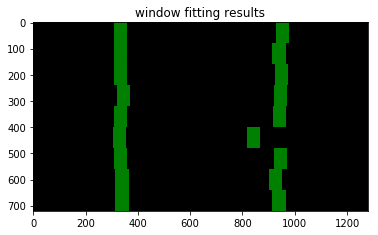

In [57]:
# Read in a thresholded image
#warped = mpimg.imread('warped_example.jpg')
warped = np.copy(top_down)
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
	    # convolve the window into the vertical slice of the image
	    image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
	    conv_signal = np.convolve(window, image_layer)
	    # Find the best left centroid by using past left center as a reference
	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
	    offset = window_width/2
	    l_min_index = int(max(l_center+offset-margin,0))
	    l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
	    l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
	    # Find the best right centroid by using past right center as a reference
	    r_min_index = int(max(r_center+offset-margin,0))
	    r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
	    r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
	    # Add what we found for that layer
	    window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
	    l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
	    r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
	    # Add graphic points from window mask here to total pixels found 
	    l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
	    r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()